### Returns

3 Types of Returns
- Session Returns - release time to current/next trading day's market open (or current day's market close for in-market)
- 1D Impact Returns - Previous Day's Close to Current Day's Close
- Horizon Returns - Short Term -5 mins to 1 hour
 
#### ToDo

- [ ] Need Last Traded Price
- [ ] Time should be in ET
- [ ] Should work for pre-market and post-market as well
- [ ] Should work for LAST TRADED stocks
- [ ] Should be adjusted prices

#### QC Doubts
- [ ] QC Changed some pricing formulas to get latest data so need to check if our returns are correct?
 



### Session Returns
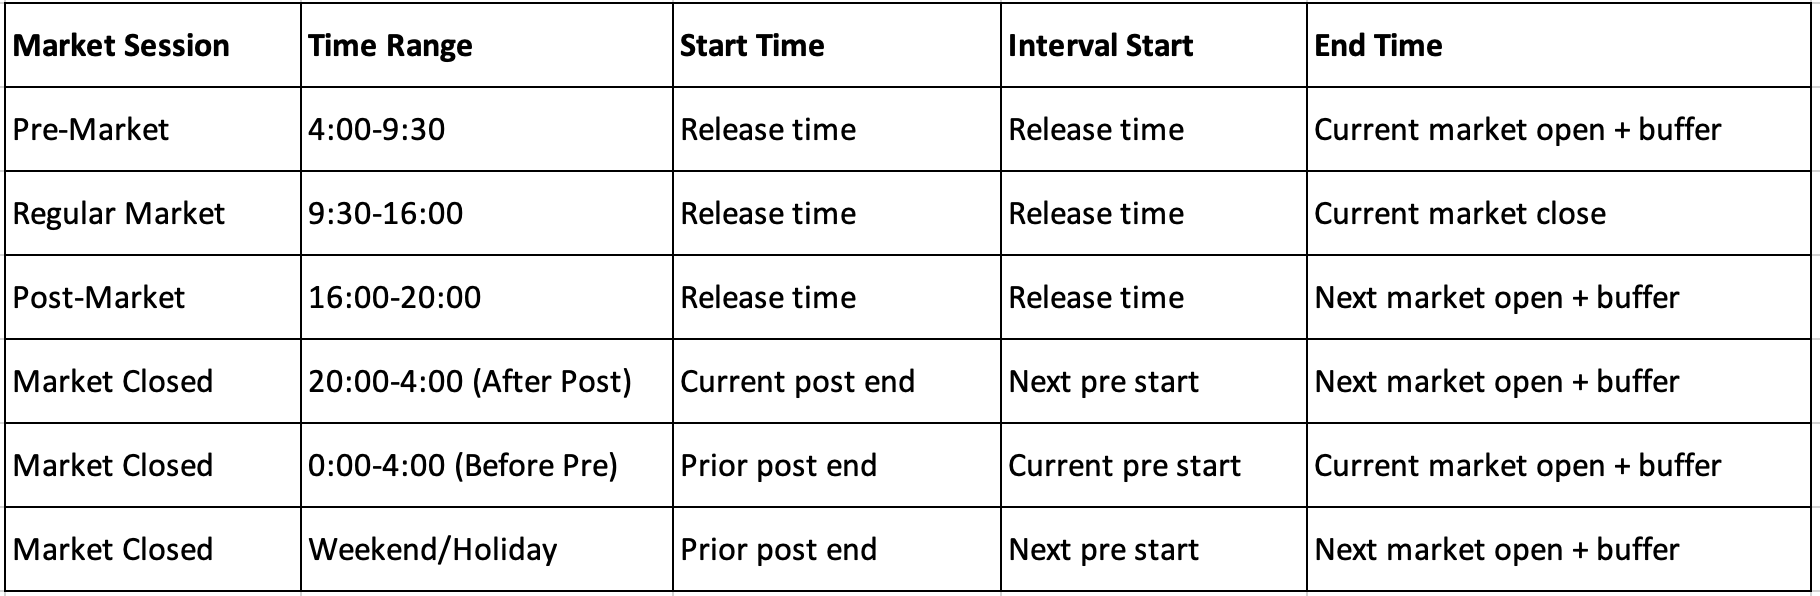

*** in above code, we could also consider for all last 3 columns for Start Time, i.e. Market Closed using Current/previous market close instead of post-end as low liquidity

**Returns**

| Market Session | Start Time                | Interval Returns Calc.                                           | Market Hours Returns                                  |
|----------------|---------------------------|------------------------------------------------------------------|-------------------------------------------------------|
| Pre-Market     | Actual release time       | ± `horizonList` intervals (in Pre Market Horizon from Actual release time) | vs Open Market + 5 minutes                           |
| In-Market      | Actual release time       | ± `horizonList` intervals (Regular Market Hours starting from Actual release time) | vs Close Market                                     |
| Post-Market    | Actual release time       | ± `horizonList` intervals (in Post Market Horizon from Actual release time) | vs Next Day's Open Market + 5 minutes               |
| Market Closed  | Previous day's end of post-market | ± `horizonList` intervals (in Pre Market Horizon from Actual release time) | vs Next Day's Open Market + 5 minutes               |



**get_start_time**
- For times classified as 'market_closed' before 4 PM or on non-trading days → Use previous day's post-market end (20:00)
- For times classified as 'market_closed' after 4 PM on trading days → Use current day's post-market end (20:00)
- For times classified as 'post_market' (16:00-20:00) → Use actual release time            
- For times classified as 'in_market' or 'pre_market' → Use actual release time

### Get start, end, interval start times

In [2]:
from utils.market_session import MarketSessionClassifier
mc = MarketSessionClassifier()
from datetime import timedelta

timestamp_str = '2017-09-22 09:29:35-04:00'
trading_hours, is_trading_day = mc.get_trading_hours(timestamp_str)
times = mc.extract_times(trading_hours)
market_session = mc.get_market_session(timestamp_str)

start_time = mc.get_start_time(timestamp_str)

end_time = mc.get_end_time(timestamp_str)
interval_start_time = mc.get_interval_start_time(timestamp_str)

oneday_impact_times = mc.get_1d_impact_times(timestamp_str)

# derived
# interval_end_time = mc.get_interval_start_time(timestamp_str) + timedelta(minutes=10)
interval_end_time = mc.get_interval_end_time(timestamp_str, 10, respect_session_boundary=True)
oneday_impact_end_time = oneday_impact_times[1]


print(f"timestamp_str: {timestamp_str}")
print(f"Market Session: {market_session}")
print(f"times: {times}")
print(f"is_trading_day: {is_trading_day}")
print(f"start_time: {start_time}")
print(f"end_time: {end_time}")
print(f"interval_start_time: {interval_start_time}")
print(f"interval_end_time: {interval_end_time}")
print(f"1d_impact_times: {oneday_impact_times}")
print(f"oneday_impact_end_time: {oneday_impact_end_time}")

timestamp_str: 2017-09-22 09:29:35-04:00
Market Session: pre_market
times: {'pre_market_current_day': Timestamp('2017-09-22 04:00:00-0400', tz='America/New_York'), 'market_open_current_day': Timestamp('2017-09-22 09:30:00-0400', tz='America/New_York'), 'market_close_current_day': Timestamp('2017-09-22 16:00:00-0400', tz='America/New_York'), 'post_market_current_day': Timestamp('2017-09-22 20:00:00-0400', tz='America/New_York'), 'pre_market_previous_day': Timestamp('2017-09-21 04:00:00-0400', tz='America/New_York'), 'market_open_previous_day': Timestamp('2017-09-21 09:30:00-0400', tz='America/New_York'), 'market_close_previous_day': Timestamp('2017-09-21 16:00:00-0400', tz='America/New_York'), 'post_market_previous_day': Timestamp('2017-09-21 20:00:00-0400', tz='America/New_York'), 'pre_market_next_day': Timestamp('2017-09-25 04:00:00-0400', tz='America/New_York'), 'market_open_next_day': Timestamp('2017-09-25 09:30:00-0400', tz='America/New_York'), 'market_close_next_day': Timestamp('2

### Polygon API

In [2]:
import pandas as pd

def fetch_newsqc():
    """Load and prepare the NewsQC.csv data"""
    # Load the data
    df = pd.read_csv('../News/NewsQC.csv', low_memory=False, on_bad_lines='warn', 
                     thousands=',', index_col=0)
    
    # Fix index 
    df.index = pd.to_numeric(df.index, errors='coerce').fillna(-1).astype(int)
    
    # Convert time columns
    df['time'] = pd.to_datetime(df['originalTime'], errors='coerce')
    df = df.dropna(subset=['time'])  # Remove rows where time is invalid
    
    return df

# Clean and convert times
def safe_convert_time(time_series):
    time_series = time_series.astype(str)
    mask = time_series.str.contains(r'\d{4}-\d{2}-\d{2}')
    time_series[~mask] = pd.NA
    return pd.to_datetime(time_series, errors='coerce', utc=True).dt.tz_convert('US/Eastern')


df = fetch_newsqc()

# Convert times
df['start_time'] = safe_convert_time(df['start_time'])
df['end_time'] = safe_convert_time(df['end_time'])

# Drop rows with invalid times or symbols
df = df.dropna(subset=['start_time', 'end_time', 'symbols'])
df.head(2)

/var/folders/jc/lcqcq2_942v3dvq5dz2hlv3w0000gn/T/ipykernel_14597/84628474.py:13: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['time'] = pd.to_datetime(df['originalTime'], errors='coerce')


,symbol,time,author,categories,contents,createdat,symbols,tags,teaser,title,...,iE15m,iE1h,iE2m,iE30m,iE5m,interval_start_price_iETF,return_iETF,start_price_iETF,RelatedEmbeddings,RelatedScores
0,ESLTF R735QTJ8XC9X,2017-09-12 05:31:51-04:00,Charles Gross,"News,Contracts",U.S. Customs and Border Protection (CBP) award...,2017-09-12 05:31:51-04:00,ESLTF,NaN,U.S. Customs and Border Protection (CBP) award...,Elbit Systems of America Awarded Contract to P...,...,0.0,0.0,0.0,0,0,85.0,-0.235291,85.0,[],[]
1,HRS R735QTJ8XC9X,2017-09-12 05:35:39-04:00,Charles Gross,"News,Contracts",Harris Corporation (NYSE: HRS ) has been award...,2017-09-12 05:35:39-04:00,HRS,NaN,NaN,Harris Corporation Awarded Development Contrac...,...,0.0,0.0,0.0,0,0,85.0,-0.235291,85.0,['10043366_1'],[0.807]


In [18]:
# Get Start and End Prices for all symbols by iterating over the dataframe

# from utils.polygonClass import Polygon

# polygon_apikey = "Q0npYHW_FKvSWnYhkPTDnpcEtDpkGu1s"
# polygon = Polygon(api_key=polygon_apikey)

# for idx, row in df.tail(100).iterrows():
#     symbol = str(row['symbols']).strip()
#     try:
#         start_price = polygon.get_last_trade(symbol, row['start_time'])
#         end_price = polygon.get_last_trade(symbol, row['end_time'])

#         print(f"Symbol: {symbol}")
#         print(f"Start Time: {row['start_time']}, Price: ${start_price:.2f}")
#         print(f"End Time: {row['end_time']}, Price: ${end_price:.2f}\n")
#     except Exception as e:
#         print(f"Error processing {symbol}: {str(e)}\n")

In [3]:
# Fast vectorized approach
ticker_timestamp_pairs_start = list(zip(df['symbols'].str.strip(), df['start_time']))
ticker_timestamp_pairs_end = list(zip(df['symbols'].str.strip(), df['end_time']))

In [4]:
ticker_timestamp_pairs_start

[('ESLTF', Timestamp('2017-09-12 05:32:00-0400', tz='US/Eastern')),
 ('HRS', Timestamp('2017-09-12 05:36:00-0400', tz='US/Eastern')),
 ('PFGC', Timestamp('2017-09-12 06:04:00-0400', tz='US/Eastern')),
 ('AA', Timestamp('2017-09-12 06:22:00-0400', tz='US/Eastern')),
 ('HLI', Timestamp('2017-09-12 06:24:00-0400', tz='US/Eastern')),
 ('STLD', Timestamp('2017-09-12 06:28:00-0400', tz='US/Eastern')),
 ('NUE', Timestamp('2017-09-12 06:28:00-0400', tz='US/Eastern')),
 ('KR', Timestamp('2017-09-12 06:29:00-0400', tz='US/Eastern')),
 ('SPTN', Timestamp('2017-09-12 06:30:00-0400', tz='US/Eastern')),
 ('BG', Timestamp('2017-09-12 06:33:00-0400', tz='US/Eastern')),
 ('ROST', Timestamp('2017-09-12 06:36:00-0400', tz='US/Eastern')),
 ('NKE', Timestamp('2017-09-12 06:37:00-0400', tz='US/Eastern')),
 ('COH', Timestamp('2017-09-12 06:37:00-0400', tz='US/Eastern')),
 ('TJX', Timestamp('2017-09-12 06:38:00-0400', tz='US/Eastern')),
 ('LULU', Timestamp('2017-09-12 06:39:00-0400', tz='US/Eastern')),
 ('VFC

In [21]:
# # Issue with this is that it calculates returns One by One
# from utils.polygonClass import Polygon
# import numpy as np
# from datetime import datetime

# polygon_apikey = "Q0npYHW_FKvSWnYhkPTDnpcEtDpkGu1s"
# polygon = Polygon(api_key=polygon_apikey)

# def get_return(polygon, symbol: str, start_time: datetime, end_time: datetime, original_time: datetime) -> float:
#     """Get return for a single symbol between two timestamps"""
#     start_price = polygon.get_last_trade(symbol, start_time)
#     end_price = polygon.get_last_trade(symbol, end_time)
    
#     if not np.isnan(start_price) and not np.isnan(end_price):
#         ret = (end_price - start_price) / start_price * 100
#         print(f"{symbol:<6}: @[{original_time}] | "
#               f"${start_price:>7.2f} [{start_time}] -> "
#               f"${end_price:>7.2f} [{end_time}] = "
#               f"{ret:>6.2f}%")
#         return ret
#     return np.nan

# # Usage:
# original_times = df.originalTime.tolist()
# for (symbol, start_time), (_, end_time), original_time in zip(ticker_timestamp_pairs_start, 
#                                                              ticker_timestamp_pairs_end,
#                                                              original_times):
#     ret = get_return(polygon, symbol, start_time, end_time, original_time)

### Test Prices of all QC Symbols using Polygon Class


In [5]:
# Get unique symbols from QCnewsSymbols.csv
import pandas as pd
symbol_list = pd.read_csv('../StocksUniverse/QCnewsSymbols.csv')['PrimarySymbol'].unique()
symbol_list = [str(s).strip().upper() for s in symbol_list if pd.notna(s)]
print(f"Found {len(symbol_list)} unique symbols")

Found 2873 unique symbols


In [6]:
from utils.polygonClass import Polygon
import pandas as pd
from time import perf_counter
from tqdm import tqdm

# polygon_apikey = "Q0npYHW_FKvSWnYhkPTDnpcEtDpkGu1s"
from eventtrader.keys import POLYGON_API_KEY
polygon = Polygon(api_key=POLYGON_API_KEY)
timestamp = pd.Timestamp('2024-09-13 16:17:00-04:00', tz='US/Eastern')
# timestamp = pd.Timestamp('2019-09-13 20:17:00-04:00', tz='US/Eastern')


# Create pairs from symbol_list
ticker_timestamp_pairs = [
    (symbol, pd.Timestamp('2024-09-13 16:17:00-04:00', tz='US/Eastern'))
    for symbol in symbol_list[:100]]

# For multiple tickers with timing and progress bar
start = perf_counter()
with tqdm(total=len(ticker_timestamp_pairs), desc="Fetching prices", ncols=100) as pbar:
    prices = polygon.get_last_trades(ticker_timestamp_pairs, pbar=pbar)
print(f"\nProcessed {len(ticker_timestamp_pairs)} tickers in {perf_counter() - start:.2f} seconds")
print(prices)


Fetching prices: 100%|████████████████████████████████████████████| 100/100 [00:02<00:00, 48.15it/s]


                      COMPLETE SUMMARY                      
Total Tickers Processed: 100
------------------------------------------------------------
                     VALIDATION METRICS                     
Valid Symbols:              100
Invalid Symbols:              0
------------------------------------------------------------
       SUCCESS METRICS (Based on Valid Symbols Only)        
✓ Prices Found :             99
✗ No Data Found:              1
  Success Rate :           99.0%
------------------------------------------------------------
                     FAILURE BREAKDOWN                      
Validation Failures:           0
  ├─ Not Found:               0
  ├─ Not Stocks Market:       0
  └─ Not Common Stock:        0

Data Failures:                1, -> ['SRCL']

Processed 100 tickers in 2.14 seconds
{'SRCL': nan, 'F': 10.69, 'NEE': 84.67, 'SPNS': 35.96, 'SMG': 69.74, 'FRPH': 29.45, 'ETN': 305.8, 'SNA': 280.44, 'EPR': 48.73, 'ESE': 119.81, 'M': 15, 'SRCE': 59.34, 'M

### Returns Calculation using Concurrency

In [7]:
len(df)

389252

In [14]:
df1 = df.iloc[0:1000].copy()
len(df1)

1000

In [26]:

# Create index_ticker_times from DataFrame
index_ticker_times = list(zip(df1.index, df1['symbols'].str.strip(), df1['start_time'], df1['end_time']))
index_ticker_times[:4]

[(0,
  'ESLTF',
  Timestamp('2017-09-12 05:32:00-0400', tz='US/Eastern'),
  Timestamp('2017-09-12 09:35:00-0400', tz='US/Eastern')),
 (1,
  'HRS',
  Timestamp('2017-09-12 05:36:00-0400', tz='US/Eastern'),
  Timestamp('2017-09-12 09:35:00-0400', tz='US/Eastern')),
 (2,
  'PFGC',
  Timestamp('2017-09-12 06:04:00-0400', tz='US/Eastern'),
  Timestamp('2017-09-12 09:35:00-0400', tz='US/Eastern')),
 (3,
  'AA',
  Timestamp('2017-09-12 06:22:00-0400', tz='US/Eastern'),
  Timestamp('2017-09-12 09:35:00-0400', tz='US/Eastern'))]

In [28]:
from utils.polygonClass import Polygon


polygon_apikey = "Q0npYHW_FKvSWnYhkPTDnpcEtDpkGu1s"
polygon = Polygon(api_key=polygon_apikey)

returns = polygon.get_returns_indexed(index_ticker_times)


No price found for DOW between 2017-09-09 07:59:00-04:00 and 2017-09-12 07:59:00-04:00
No price found for DOW between 2017-09-09 11:38:00-04:00 and 2017-09-12 11:38:00-04:00
No price found for DOW between 2017-09-10 11:15:00-04:00 and 2017-09-13 11:15:00-04:00
No price found for DOW between 2017-09-10 07:10:00-04:00 and 2017-09-13 07:10:00-04:00
No price found for DOW between 2017-09-12 08:06:00-04:00 and 2017-09-15 08:06:00-04:00
No price found for CAPN between 2017-09-12 08:06:00-04:00 and 2017-09-15 08:06:00-04:00
No price found for DOW between 2017-09-16 11:02:00-04:00 and 2017-09-19 11:02:00-04:00
No price found for DOW between 2017-09-16 07:36:00-04:00 and 2017-09-19 07:36:00-04:00
No price found for DOW between 2017-09-23 07:27:00-04:00 and 2017-09-26 07:27:00-04:00
No price found for NB between 2017-09-24 08:55:00-04:00 and 2017-09-27 08:55:00-04:00
No price found for ROKU between 2017-09-25 04:45:00-04:00 and 2017-09-28 04:45:00-04:00
No price found for DOW between 2017-09-09 

In [30]:
returns

{0: nan,
 1: nan,
 2: 0.5309734513274286,
 3: 2.5028702640643017,
 4: -0.22166805209200718,
 5: -1.9461077844311336,
 6: -1.3059701492537368,
 7: -0.06973500697350334,
 8: -0.3410059676044409,
 9: -4.255181518151809,
 10: 0.624261852539223,
 11: 1.2492509363295972,
 12: nan,
 13: 0.7138934651290445,
 14: -0.27397260273971735,
 15: 0.24463383838384017,
 16: 0.34722222222223537,
 17: nan,
 18: 2.1072285942918088,
 19: 2.444987775061125,
 20: 2.831460674157304,
 21: 1.2962962962963016,
 22: 0.21474588403721803,
 23: -1.62605932203391,
 24: -0.5293070643834825,
 25: 1.8308631211857094,
 26: 0.2118394727550981,
 27: 0.2220144893666718,
 28: -4.255181518151809,
 29: nan,
 30: -0.1702127659574432,
 31: nan,
 32: nan,
 33: 1.6377649325626198,
 34: 0.3931623931623878,
 35: 0.3570737252220918,
 36: -2.6020408163265385,
 37: 0.2250080360012943,
 38: 1.065520692294113,
 39: 1.4186339486224482,
 40: 0.17046944662994418,
 41: nan,
 42: 0.4203161862407494,
 43: -0.18503955220427318,
 44: -0.853978185

In [16]:
import pandas as pd
from time import perf_counter
from tqdm import tqdm


with tqdm(total=len(index_ticker_times)*2) as pbar: # *2 because we fetch start and end prices
    returns = polygon.get_returns_indexed(index_ticker_times, pbar)    

  0%|          | 0/2000 [00:00<?, ?it/s]

No price found for DOW between 2017-09-09 07:59:00-04:00 and 2017-09-12 07:59:00-04:00
No price found for DOW between 2017-09-09 11:38:00-04:00 and 2017-09-12 11:38:00-04:00
No price found for DOW between 2017-09-10 07:10:00-04:00 and 2017-09-13 07:10:00-04:00
No price found for DOW between 2017-09-10 11:15:00-04:00 and 2017-09-13 11:15:00-04:00
No price found for CAPN between 2017-09-12 08:06:00-04:00 and 2017-09-15 08:06:00-04:00
No price found for DOW between 2017-09-12 08:06:00-04:00 and 2017-09-15 08:06:00-04:00
No price found for DOW between 2017-09-16 07:36:00-04:00 and 2017-09-19 07:36:00-04:00
No price found for DOW between 2017-09-16 11:02:00-04:00 and 2017-09-19 11:02:00-04:00


  0%|          | 6/2000 [00:12<38:57,  1.17s/it]  

No price found for DOW between 2017-09-23 07:27:00-04:00 and 2017-09-26 07:27:00-04:00


  0%|          | 10/2000 [00:14<16:19,  2.03it/s]

No price found for NB between 2017-09-24 08:55:00-04:00 and 2017-09-27 08:55:00-04:00


  1%|          | 14/2000 [00:15<09:27,  3.50it/s]

No price found for ROKU between 2017-09-25 04:45:00-04:00 and 2017-09-28 04:45:00-04:00


 50%|████▉     | 994/2000 [00:19<00:06, 161.01it/s]

No price found for DOW between 2017-09-09 09:35:00-04:00 and 2017-09-12 09:35:00-04:00
No price found for CAPN between 2017-09-12 09:35:00-04:00 and 2017-09-15 09:35:00-04:00No price found for DOW between 2017-09-10 16:00:00-04:00 and 2017-09-13 16:00:00-04:00
No price found for DOW between 2017-09-09 16:00:00-04:00 and 2017-09-12 16:00:00-04:00



 51%|█████     | 1024/2000 [00:22<00:18, 53.69it/s]

No price found for DOW between 2017-09-10 09:35:00-04:00 and 2017-09-13 09:35:00-04:00
No price found for DOW between 2017-09-12 09:35:00-04:00 and 2017-09-15 09:35:00-04:00


 53%|█████▎    | 1054/2000 [00:26<01:25, 11.01it/s]

No price found for DOW between 2017-09-16 09:35:00-04:00 and 2017-09-19 09:35:00-04:00
No price found for DOW between 2017-09-16 16:00:00-04:00 and 2017-09-19 16:00:00-04:00


 94%|█████████▍| 1875/2000 [00:29<00:00, 151.36it/s]

No price found for DOW between 2017-09-23 09:35:00-04:00 and 2017-09-26 09:35:00-04:00
No price found for ROKU between 2017-09-25 09:35:00-04:00 and 2017-09-28 09:35:00-04:00
No price found for NB between 2017-09-24 09:35:00-04:00 and 2017-09-27 09:35:00-04:00


100%|██████████| 2000/2000 [00:31<00:00, 63.90it/s] 


In [13]:
returns

{0: nan,
 1: nan,
 2: 0.5309734513274286,
 3: 2.5028702640643017,
 4: -0.22166805209200718,
 5: -1.9461077844311336,
 6: -1.3059701492537368,
 7: -0.06973500697350334,
 8: -0.3410059676044409,
 9: -4.255181518151809,
 10: 0.624261852539223,
 11: 1.2492509363295972,
 12: nan,
 13: 0.7138934651290445,
 14: -0.27397260273971735,
 15: 0.24463383838384017,
 16: 0.34722222222223537,
 17: nan,
 18: 2.1072285942918088,
 19: 2.444987775061125,
 20: 2.831460674157304,
 21: 1.2962962962963016,
 22: 0.21474588403721803,
 23: -1.62605932203391,
 24: -0.5293070643834825,
 25: 1.8308631211857094,
 26: 0.2118394727550981,
 27: 0.2220144893666718,
 28: -4.255181518151809,
 29: nan,
 30: -0.1702127659574432,
 31: nan,
 32: nan,
 33: 1.6377649325626198,
 34: 0.3931623931623878,
 35: 0.3570737252220918,
 36: -2.6020408163265385,
 37: 0.2250080360012943,
 38: 1.065520692294113,
 39: 1.4186339486224482,
 40: 0.17046944662994418,
 41: nan,
 42: 0.4203161862407494,
 43: -0.18503955220427318,
 44: -0.853978185

In [1]:
index_ticker_times

NameError: name 'index_ticker_times' is not defined

### Saves SessionReturns_QC.csv in Batches

In [ ]:
# from utils.polygonClass import Polygon
# import pandas as pd
# from time import perf_counter
# from tqdm import tqdm

# polygon_apikey = "Q0npYHW_FKvSWnYhkPTDnpcEtDpkGu1s"
# polygon = Polygon(api_key=polygon_apikey)


# # Create index_ticker_times from DataFrame
# index_ticker_times = list(zip(df.index, df['symbols'].str.strip(), df['start_time'], df['end_time']))


# batch_size = 5000
# returns = {}

# total_pairs = len(index_ticker_times)
# n_batches = (total_pairs + batch_size - 1) // batch_size

# filename = 'SessionReturns_QC_v1.csv'  # Single file

# with tqdm(total=total_pairs*2) as pbar:
#     try:
#         for i in range(0, total_pairs, batch_size):
#             batch = index_ticker_times[i:i+batch_size]
#             batch_returns = polygon.get_returns_indexed(batch, pbar)
#             returns.update(batch_returns)
            
#             # Update DataFrame and save to single file
#             df['returns'] = pd.Series(returns)
#             df.to_csv(filename, index=True)
#             print(f"\nSaved batch {i//batch_size + 1}/{n_batches}")
            
#     except KeyboardInterrupt:
#         print(f"\nProcess interrupted! Saved {len(returns)} results out of {total_pairs}")
#         # Final state is already saved in the file  

This:
    Tracks last successful batch
    Can resume from where it left off
    Preserves existing results
    Shows timestamps for monitoring
    Handles both interrupts and errors

In [ ]:
import os
from datetime import datetime
from utils.polygonClass import Polygon
import pandas as pd
from time import perf_counter
from tqdm import tqdm

# Keep track of last successful batch
last_batch_file = 'last_successful_batch.txt'

# Load last successful batch if exists
start_batch = 0
if os.path.exists(last_batch_file):
    with open(last_batch_file, 'r') as f:
        start_batch = int(f.read().strip())
        print(f"Resuming from batch {start_batch}")

batch_size = 5000
returns = {}

total_pairs = len(index_ticker_times)
n_batches = (total_pairs + batch_size - 1) // batch_size

filename = 'SessionReturns_QC_v1.csv'

# Load existing returns if any
if os.path.exists(filename) and os.path.getsize(filename) > 0:
    existing_df = pd.read_csv(filename, index_col=0)
    if 'returns' in existing_df.columns:
        returns = existing_df['returns'].to_dict()
        print(f"Loaded {len(returns)} existing returns")

with tqdm(total=total_pairs*2) as pbar:
    try:
        for i in range(start_batch * batch_size, total_pairs, batch_size):
            batch = index_ticker_times[i:i+batch_size]
            batch_returns = polygon.get_returns_indexed(batch, pbar)
            returns.update(batch_returns)
            
            # Save progress
            df['returns'] = pd.Series(returns)
            df.to_csv(filename, index=True)
            
            # Save last successful batch
            with open(last_batch_file, 'w') as f:
                f.write(str(i // batch_size))
                
            print(f"\nSaved batch {i//batch_size + 1}/{n_batches}")
            print(f"Timestamp: {datetime.now()}")
            
    except (KeyboardInterrupt, Exception) as e:
        print(f"\nProcess interrupted! Error: {str(e)}")
        print(f"Saved {len(returns)} results out of {total_pairs}")
        # Data is already saved in the last successful batch

### One consolidated function that:
- takes in a date and ticker,return_type: session, 1d impact, horizon
- returns stock returns, sector etf returns and industry etf returns (is trading day)?
- ?should it ideally return datetime for each return (actual time found in polygon)


PLAN:



#### Fetch final_symbols.csv

In [17]:
import pandas as pd
from utils.misc import get_unique_items
symbols_df = pd.read_csv('../StocksUniverse/final_symbols.csv')
print(f"{len(symbols_df)} symbols")
print(f"Unique Ticker Count: {get_unique_items(symbols_df, 'cik')}")
symbols_df.head()

831 symbols
Unique Ticker Count: 831


,cik,symbol,root,company_name,cusip,figi,class_figi,exchange,related,sector,...,mkt_cap,employees,shares_out,ipo_date,win_rate,total_count,recent_count,avg_abs_return,max_return,min_return
0,37785,FMC,FMC,FMC CORP,302491303,BBG000BJP882,BBG001S5R880,NYS,['CTVA'],BasicMaterials,...,6.669965e+09,6600.0,124840000.0,1986-05-29,0.612565,191.0,127.0,1.267042,5.355819,-7.628036
1,825542,SMG,SMG,SCOTTS MIRACLE-GRO CO,810186106,BBG000BT5PG5,BBG001S5W5H0,NYS,[],BasicMaterials,...,4.034961e+09,5300.0,57450000.0,1992-01-31,0.575163,153.0,109.0,2.225626,9.063994,-16.911301
2,30625,FLS,FLS,FLOWSERVE CORP,34354P105 266849108,BBG000FFH4P5,BBG001SB3F87,NYS,"['AIT', 'IR', 'GGG', 'GHM', 'CR', 'ITT', 'EMR'...",Industrials,...,8.342406e+09,16000.0,131380000.0,1972-06-30,0.716981,106.0,73.0,1.868360,14.005894,-7.296652
3,88941,SMTC,SMTC,SEMTECH CORP,816850101,BBG000DBKR53,BBG001S7TWW4,NAS,"['ANET', 'DIOD', 'MTSI', 'MKSI', 'TER', 'NXPI'...",Technology,...,6.463417e+09,1917.0,84530000.0,1992-03-17,0.509677,155.0,88.0,2.758607,18.757845,-29.120439
4,883241,SNPS,SNPS,SYNOPSYS INC,871607107,BBG000BSFRF3,BBG001S5VTR8,NAS,"['CDNS', 'ASUR', 'AZPN', 'ANSS', 'SNOW', 'META...",Technology,...,8.117079e+10,20300.0,153610000.0,1992-03-03,0.521073,261.0,151.0,1.188107,9.108615,-3.558390


In [18]:
from eventtrader.keys import POLYGON_API_KEY
from utils.polygonClass import Polygon
polygon = Polygon(api_key=POLYGON_API_KEY)
import json


event_timestamp = '2022-09-22 09:29:35-04:00'
stock_ticker = 'AAPL'
sector_etf = 'XLK'
industry_etf = 'IGV'


#### session returns (single stock)

In [19]:
session_returns = polygon.get_event_returns(
    ticker="AAPL",
    sector_etf="XLK",
    industry_etf="IGV",
    event_timestamp=event_timestamp,
    return_type="session"
)
session_returns


{'stock': 0.6706114398422158,
 'sector': 0.05546751188589,
 'industry': -0.6283524904214616,
 'macro': 0.04516711833785428}

#### 1d_impact returns (single stock)

In [20]:
# 2. 1-Day Impact Returns
impact_returns = polygon.get_event_returns(
    ticker="AAPL",
    sector_etf="XLK",
    industry_etf="IGV",
    event_timestamp=event_timestamp,
    return_type="1d_impact"
)

impact_returns


{'stock': -0.6310584867607825,
 'sector': -1.0183942527828265,
 'industry': -1.511422198292428,
 'macro': -0.8637820937442164}

#### horizon returns (single stock)

In [21]:

# Example usage for horizon returns
horizon_returns = polygon.get_event_returns(
    ticker="AAPL",
    sector_etf="XLK",
    industry_etf="IGV",
    event_timestamp=event_timestamp,
    return_type="horizon",
    horizon_minutes=[60]
)

horizon_returns

{'stock': [0.2539776462853423],
 'sector': [-0.3803486529318573],
 'industry': [-1.406130268199237],
 'macro': [-0.19660980923534968]}

## Batch Async returns (multiple stocks)




**creating inputs for multiple stocks returns**


In [22]:
from utils.fetchLocalcsv import load_local_csv 

symbols_df = load_local_csv('../StocksUniverse/final_symbols.csv', keep_cols=['symbol', 'sector_etf', 'industry_etf'])
news_df = load_local_csv('../News/NewsQC.csv', keep_cols=['symbols', 'Unnamed: 0', 'originalTime'])
news_df.columns = ['idx','symbol', 'originalTime']

# Restrict to only keep symbols that are in symbols_df
print(f"Length of news_df: {len(news_df)}")
news_df = news_df[news_df['symbol'].isin(symbols_df['symbol'])]
print(f"Length of news_df after filtering: {len(news_df)}")

# Merge DataFrames
news_df = news_df.merge(symbols_df, on='symbol', how='left')
news_df.dropna(subset=['sector_etf', 'industry_etf'], inplace=True)
news_df.sort_values(by='idx', ascending=False)
news_df.set_index('idx', inplace=True, drop=True)

news_df.head(2)

Loaded ../StocksUniverse/final_symbols.csv with 831 rows and 3 columns
Loaded ../News/NewsQC.csv with 389253 rows and 3 columns
Length of news_df: 389253
Length of news_df after filtering: 215303


,symbol,originalTime,sector_etf,industry_etf
idx,,,,
2,PFGC,2017-09-12 06:03:40-04:00,XLP,RTH
3,AA,2017-09-12 06:21:58-04:00,XLB,XME


In [31]:
from eventtrader.keys import POLYGON_API_KEY
from utils.polygonClass import Polygon
polygon = Polygon(api_key=POLYGON_API_KEY)
news_df_original = news_df.copy()
news_df = news_df.iloc[0:200]
news_df.head(2)


,symbol,originalTime,sector_etf,industry_etf
idx,,,,
2,PFGC,2017-09-12 06:03:40-04:00,XLP,RTH
3,AA,2017-09-12 06:21:58-04:00,XLB,XME


- 'stock'
- 'sector'
- 'industry'
- 'macro'

In [32]:
asset_types = ['stock', 'sector', 'industry', 'macro']
horizon_minutes = [-30, 30]


In [33]:


# def get_structured_returns(news_df: pd.DataFrame, return_type: str = 'session', horizon_minutes: Optional[List[int]] = None) -> pd.DataFrame:
#     pairs = polygon.prepare_time_pairs(news_df, return_type, horizon_minutes)
#     returns = {f"{asset}{h}" if return_type == 'horizon' else f"{asset}_{return_type}": polygon.get_returns_indexed(pairs[h][asset] if return_type == 'horizon' else pairs[asset])
#               for h in (pairs.keys() if return_type == 'horizon' else [''])
#               for asset in ['stock', 'sector', 'industry', 'macro']}
#     return pd.DataFrame.from_dict(returns, orient='columns')


polygon.get_structured_returns(news_df, return_type='session', horizon_minutes=horizon_minutes) # session, 1d_impact, horizon


No price found for DOW between 2017-09-10 07:09:33-04:00 and 2017-09-13 07:09:33-04:00
No price found for DOW between 2017-09-09 07:58:57-04:00 and 2017-09-12 07:58:57-04:00
No price found for DOW between 2017-09-09 11:37:59-04:00 and 2017-09-12 11:37:59-04:00
No price found for DOW between 2017-09-09 09:35:00-04:00 and 2017-09-12 09:35:00-04:00
No price found for DOW between 2017-09-16 11:01:28-04:00 and 2017-09-19 11:01:28-04:00
No price found for DOW between 2017-09-16 07:35:01-04:00 and 2017-09-19 07:35:01-04:00
No price found for DOW between 2017-09-10 11:15:00-04:00 and 2017-09-13 11:15:00-04:00
No price found for DOW between 2017-09-12 08:05:55-04:00 and 2017-09-15 08:05:55-04:00
No price found for DOW between 2017-09-10 16:00:00-04:00 and 2017-09-13 16:00:00-04:00
No price found for DOW between 2017-09-12 09:35:00-04:00 and 2017-09-15 09:35:00-04:00
No price found for DOW between 2017-09-09 16:00:00-04:00 and 2017-09-12 16:00:00-04:00
No price found for DOW between 2017-09-10 0

,stock_session,sector_session,industry_session,macro_session
2,0.530973,0.216685,0.000000,0.116218
3,2.502870,0.968778,0.000000,0.092151
5,-1.946108,0.968778,-0.617566,0.092151
6,-1.305970,0.968778,-0.617566,0.092151
7,-0.069735,0.216685,0.000000,0.092151
...,...,...,...,...
336,1.234568,NaN,NaN,0.012524
341,-0.191414,-0.011204,0.049788,0.060048
342,0.068074,NaN,0.340289,0.052037
344,NaN,0.452007,0.452007,0.112148


In [ ]:

polygon.get_structured_returns(news_df, return_type='1d_impact', horizon_minutes=horizon_minutes) # session, 1d_impact, horizon

In [ ]:
polygon.get_structured_returns(news_df, return_type='horizon', horizon_minutes=horizon_minutes) # session, 1d_impact, horizon

In [ ]:
news_df.index.tolist()

### Get Sector and Industry from official SEC site but no need since already have it in symbols_df from sec-api

In [ ]:
# import yfinance as yf
# from tqdm import tqdm

# # Add new columns
# symbols_df['sector'] = None
# symbols_df['industry'] = None

# def get_yf_sector_industry(ticker: str):
#     try:
#         stock = yf.Ticker(ticker)
#         info = stock.info
#         return {
#             'sector': info.get('sector'),
#             'industry': info.get('industry')
#         }
#     except Exception as e:
#         print(f"Error fetching data for {ticker}: {str(e)}")
#         return None

# # Update DataFrame
# for idx, row in tqdm(symbols_df.iterrows(), desc="Fetching sector/industry"):
#     info = get_yf_sector_industry(row['ticker'])
#     if info:
#         symbols_df.loc[row['ticker'], ['sector', 'industry']] = [info['sector'], info['industry']]

# # Show sample
# print(symbols_df[['sector', 'industry']].head())

In [ ]:
# import requests
# from tqdm import tqdm

# def get_sec_company_info(cik: str):
#     try:
#         # Convert CIK to string and pad with zeros to 10 digits
#         cik_str = str(int(cik)).zfill(10)
#         url = f"https://data.sec.gov/submissions/CIK{cik_str}.json"
#         headers = {'User-Agent': 'Company Name companyemail@domain.com'}  # SEC requires user-agent
#         response = requests.get(url, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             return {
#                 'sic': data.get('sic'),
#                 'sic_description': data.get('sicDescription'),
#                 'industry': data.get('industry'),
#                 'sector': data.get('sector')
#             }
#     except Exception as e:
#         print(f"Error fetching SEC data for CIK {cik}: {str(e)}")
#     return None
# # First, add new columns if they don't exist
# symbols_df['sec_sic'] = None
# symbols_df['sec_sic_description'] = None
# symbols_df['sec_industry'] = None
# symbols_df['sec_sector'] = None

# # Track success/failure counts
# success = 0
# failed = 0

# # Then fetch and update data
# for idx, row in tqdm(symbols_df.iterrows(), desc="Fetching SEC data"):
#     if pd.notna(row['cik']):
#         info = get_sec_company_info(row['cik'])
#         if info:
#             try:
#                 symbols_df.loc[idx, ['sec_sic', 'sec_sic_description', 'sec_industry', 'sec_sector']] = [
#                     info['sic'], 
#                     info['sic_description'], 
#                     info['industry'], 
#                     info['sector']
#                 ]
#                 print(info)
#                 success += 1
#             except Exception as e:
#                 print(f"Error updating row for {idx}: {str(e)}")
                
#                 failed += 1

# print(f"\nProcessed {success + failed} companies:")
# print(f"Success: {success}")
# print(f"Failed: {failed}")

# # Show the first few rows with new columns
# print("\nSample of updated data:")
# print(symbols_df[['sec_sic', 'sec_sic_description', 'sec_industry', 'sec_sector']].head())
# symbols_df.dropna(subset=['sec_industry'])